# Portfolio Tiltato: 70% Contrarian + 30% TSMOM

**Analisi di un portfolio tiltato che combina strategie TSMOM e Contrarian con allocation intelligente basata sulla performance osservata.**

## Portfolio Logic
- **Tilted Weight**: 70% Contrarian + 30% TSMOM (bias verso strategie vincenti)
- **Equal Weight Within Type**: Contrarian: 17.5% each, TSMOM: 7.5% each
- **Weekly Rebalancing**: Ogni Venerdì (coerente con logica esistente)
- **Performance-Based**: Allocation basata su performance osservate
- **Risk Reduction**: Diversificazione ma non neutralizzazione

## Expected Improvements vs Equal Weight
- **Higher Returns**: Bias verso strategie positive (Contrarian)
- **Better Sharpe**: Migliore risk-adjusted performance  
- **Smoother Equity**: Diversificazione riduce volatilità
- **Reduced Drawdowns**: TSMOM modera drawdown contrarian

In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All imports loaded successfully!")

✅ All imports loaded successfully!


In [2]:
# Load existing equity curves and returns from parquet files
print("📊 Loading existing strategy data...")

equity_curves = pd.read_parquet('../results/weekly_weekly_equity_curves.parquet')
returns_data = pd.read_parquet('../results/weekly_weekly_returns.parquet')

print(f"✅ Equity curves loaded: {equity_curves.shape}")
print(f"✅ Returns data loaded: {returns_data.shape}")
print(f"📅 Date range: {equity_curves.index[0].strftime('%Y-%m-%d')} → {equity_curves.index[-1].strftime('%Y-%m-%d')}")
print(f"🔢 Total weeks: {len(equity_curves)}")
print(f"📈 Strategies: {list(equity_curves.columns)}")

# Separate TSMOM and Contrarian strategies
tsmom_strategies = [col for col in equity_curves.columns if col.startswith('TSMOM')]
contrarian_strategies = [col for col in equity_curves.columns if col.startswith('CONTRARIAN')]

print(f"\n🔄 TSMOM Strategies ({len(tsmom_strategies)}): {tsmom_strategies}")
print(f"🔀 Contrarian Strategies ({len(contrarian_strategies)}): {contrarian_strategies}")

📊 Loading existing strategy data...
✅ Equity curves loaded: (1337, 8)
✅ Returns data loaded: (1337, 8)
📅 Date range: 2000-01-07 → 2025-08-15
🔢 Total weeks: 1337
📈 Strategies: ['TSMOM_1W', 'TSMOM_2W', 'TSMOM_4W', 'TSMOM_8W', 'CONTRARIAN_1W', 'CONTRARIAN_2W', 'CONTRARIAN_4W', 'CONTRARIAN_8W']

🔄 TSMOM Strategies (4): ['TSMOM_1W', 'TSMOM_2W', 'TSMOM_4W', 'TSMOM_8W']
🔀 Contrarian Strategies (4): ['CONTRARIAN_1W', 'CONTRARIAN_2W', 'CONTRARIAN_4W', 'CONTRARIAN_8W']


In [3]:
class TiltedPortfolioBuilder:
    """
    Portfolio builder for 70% Contrarian / 30% TSMOM allocation.
    
    Implements performance-based tilting with weekly rebalancing
    and comprehensive diversification analysis.
    """
    
    def __init__(self):
        self.portfolio_returns = None
        self.portfolio_equity = None
        self.strategy_weights = None
        
    def build_tilted_portfolio(self, returns_data: pd.DataFrame, 
                              contrarian_weight: float = 0.7) -> pd.Series:
        """
        Build tilted portfolio: 70% Contrarian + 30% TSMOM.
        
        Args:
            returns_data: DataFrame with strategy returns
            contrarian_weight: Weight for contrarian strategies (default 0.7)
            
        Returns:
            Series with portfolio returns
        """
        # Separate strategy types
        tsmom_strategies = [col for col in returns_data.columns if col.startswith('TSMOM')]
        contrarian_strategies = [col for col in returns_data.columns if col.startswith('CONTRARIAN')]
        
        # Calculate weights
        tsmom_weight = 1 - contrarian_weight
        
        # Equal weight within each strategy type
        contrarian_individual_weight = contrarian_weight / len(contrarian_strategies)
        tsmom_individual_weight = tsmom_weight / len(tsmom_strategies)
        
        # Build weight vector
        weights = pd.Series(index=returns_data.columns, dtype=float)
        weights[contrarian_strategies] = contrarian_individual_weight
        weights[tsmom_strategies] = tsmom_individual_weight
        
        # Calculate portfolio returns as weighted average
        portfolio_returns = returns_data.dot(weights)
        
        # Store for later analysis
        self.portfolio_returns = portfolio_returns
        self.strategy_weights = weights
        
        print(f"Portfolio Allocation:")
        print(f"  Contrarian: {contrarian_weight*100:.0f}% ({contrarian_individual_weight*100:.1f}% each)")
        print(f"  TSMOM: {tsmom_weight*100:.0f}% ({tsmom_individual_weight*100:.1f}% each)")
        
        return portfolio_returns
    
    def calculate_portfolio_equity(self, portfolio_returns: pd.Series) -> pd.Series:
        """
        Calculate portfolio equity curve from returns.
        """
        portfolio_equity = (1 + portfolio_returns).cumprod()
        self.portfolio_equity = portfolio_equity
        return portfolio_equity
    
    def calculate_portfolio_metrics(self, portfolio_returns: pd.Series) -> dict:
        """
        Calculate comprehensive portfolio performance metrics.
        """
        # Basic performance metrics (weekly frequency)
        total_return = (1 + portfolio_returns).prod() - 1
        annual_return = portfolio_returns.mean() * 52
        annual_vol = portfolio_returns.std() * np.sqrt(52)
        sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else np.nan
        
        # Drawdown calculation
        equity_curve = (1 + portfolio_returns).cumprod()
        running_max = equity_curve.expanding().max()
        drawdown = (equity_curve - running_max) / running_max
        max_drawdown = drawdown.min()
        
        # Additional risk metrics
        var_95 = portfolio_returns.quantile(0.05)
        var_99 = portfolio_returns.quantile(0.01)
        
        return {
            'Total_Return': total_return,
            'Annual_Return': annual_return,
            'Annual_Vol': annual_vol,
            'Sharpe_Ratio': sharpe_ratio,
            'Max_Drawdown': max_drawdown,
            'VaR_95': var_95,
            'VaR_99': var_99,
            'Skewness': portfolio_returns.skew(),
            'Kurtosis': portfolio_returns.kurtosis()
        }
    
    def calculate_individual_metrics(self, returns_data: pd.DataFrame) -> pd.DataFrame:
        """
        Calculate metrics for all individual strategies.
        """
        individual_metrics = {}
        for strategy in returns_data.columns:
            strategy_returns = returns_data[strategy]
            metrics = self.calculate_portfolio_metrics(strategy_returns)
            individual_metrics[strategy] = metrics
        
        return pd.DataFrame(individual_metrics).T

print("✅ TiltedPortfolioBuilder class defined!")

✅ TiltedPortfolioBuilder class defined!


In [4]:
# Initialize portfolio builder
portfolio_builder = TiltedPortfolioBuilder()

# Build 70/30 tilted portfolio (70% Contrarian, 30% TSMOM)
print("🏗️ Building 70% Contrarian / 30% TSMOM portfolio...")
portfolio_returns = portfolio_builder.build_tilted_portfolio(returns_data, contrarian_weight=0.7)
portfolio_equity = portfolio_builder.calculate_portfolio_equity(portfolio_returns)

print(f"\n✅ Portfolio constructed with {len(returns_data.columns)} strategies")
print(f"📊 Portfolio weights:")
for strategy, weight in portfolio_builder.strategy_weights.items():
    print(f"   {strategy}: {weight*100:.1f}%")

print(f"\n📈 Portfolio final value: {portfolio_equity.iloc[-1]:.4f}")
print(f"💰 Portfolio total return: {(portfolio_equity.iloc[-1] - 1) * 100:+.2f}%")

# Calculate portfolio metrics
portfolio_metrics = portfolio_builder.calculate_portfolio_metrics(portfolio_returns)
individual_metrics = portfolio_builder.calculate_individual_metrics(returns_data)

print(f"\n📋 Portfolio Performance Summary:")
print(f"   Annual Return: {portfolio_metrics['Annual_Return'] * 100:+.2f}%")
print(f"   Annual Volatility: {portfolio_metrics['Annual_Vol'] * 100:.2f}%")
print(f"   Sharpe Ratio: {portfolio_metrics['Sharpe_Ratio']:.3f}")
print(f"   Max Drawdown: {portfolio_metrics['Max_Drawdown'] * 100:.2f}%")

🏗️ Building 70% Contrarian / 30% TSMOM portfolio...
Portfolio Allocation:
  Contrarian: 70% (17.5% each)
  TSMOM: 30% (7.5% each)

✅ Portfolio constructed with 8 strategies
📊 Portfolio weights:
   TSMOM_1W: 7.5%
   TSMOM_2W: 7.5%
   TSMOM_4W: 7.5%
   TSMOM_8W: 7.5%
   CONTRARIAN_1W: 17.5%
   CONTRARIAN_2W: 17.5%
   CONTRARIAN_4W: 17.5%
   CONTRARIAN_8W: 17.5%

📈 Portfolio final value: 1.0888
💰 Portfolio total return: +8.88%

📋 Portfolio Performance Summary:
   Annual Return: +0.34%
   Annual Volatility: 1.39%
   Sharpe Ratio: 0.246
   Max Drawdown: -5.30%


In [5]:
# Performance Comparison Analysis
print("📊 Portfolio vs Individual Strategy Comparison")
print("=" * 60)

# Add portfolio to comparison
portfolio_row = pd.DataFrame([portfolio_metrics], index=['TILTED_PORTFOLIO_70_30'])
full_comparison = pd.concat([individual_metrics, portfolio_row])

# Display comparison table
display_cols = ['Annual_Return', 'Annual_Vol', 'Sharpe_Ratio', 'Max_Drawdown']
comparison_display = full_comparison[display_cols].copy()

# Format for display
comparison_display['Annual_Return'] = (comparison_display['Annual_Return'] * 100).round(2)
comparison_display['Annual_Vol'] = (comparison_display['Annual_Vol'] * 100).round(2)
comparison_display['Sharpe_Ratio'] = comparison_display['Sharpe_Ratio'].round(3)
comparison_display['Max_Drawdown'] = (comparison_display['Max_Drawdown'] * 100).round(2)

print(comparison_display)

# Find best individual strategy
best_individual = individual_metrics['Sharpe_Ratio'].idxmax()
best_sharpe = individual_metrics.loc[best_individual, 'Sharpe_Ratio']
portfolio_sharpe = portfolio_metrics['Sharpe_Ratio']

print(f"\n🏆 Best Individual Strategy: {best_individual} (Sharpe: {best_sharpe:.3f})")
print(f"📊 Portfolio Sharpe: {portfolio_sharpe:.3f}")
print(f"🎯 Portfolio vs Best: {portfolio_sharpe - best_sharpe:+.3f} Sharpe difference")

# Average individual performance
avg_individual_sharpe = individual_metrics['Sharpe_Ratio'].mean()
print(f"📈 Average Individual Sharpe: {avg_individual_sharpe:.3f}")
print(f"🔄 Portfolio vs Average: {portfolio_sharpe - avg_individual_sharpe:+.3f} Sharpe improvement")

# Strategy type analysis
tsmom_avg_performance = individual_metrics.loc[tsmom_strategies].mean()
contrarian_avg_performance = individual_metrics.loc[contrarian_strategies].mean()

print(f"\n📈 TSMOM Average Performance:")
print(f"   Annual Return: {tsmom_avg_performance['Annual_Return'] * 100:+.2f}%")
print(f"   Sharpe Ratio: {tsmom_avg_performance['Sharpe_Ratio']:.3f}")

print(f"\n📉 Contrarian Average Performance:")
print(f"   Annual Return: {contrarian_avg_performance['Annual_Return'] * 100:+.2f}%")
print(f"   Sharpe Ratio: {contrarian_avg_performance['Sharpe_Ratio']:.3f}")

# Expected vs actual analysis
expected_tilted = 0.7 * contrarian_avg_performance['Annual_Return'] + 0.3 * tsmom_avg_performance['Annual_Return']
actual_tilted = portfolio_metrics['Annual_Return']
diversification_alpha = actual_tilted - expected_tilted

print(f"\n🎯 Performance Attribution:")
print(f"   Expected Return (70/30 mix): {expected_tilted * 100:+.2f}%")
print(f"   Actual Portfolio Return: {actual_tilted * 100:+.2f}%")
print(f"   Diversification Alpha: {diversification_alpha * 100:+.2f}%")

📊 Portfolio vs Individual Strategy Comparison
                        Annual_Return  Annual_Vol  Sharpe_Ratio  Max_Drawdown
TSMOM_1W                        -1.06        4.13        -0.258        -28.46
TSMOM_2W                        -1.09        4.12        -0.263        -25.97
TSMOM_4W                        -0.83        4.19        -0.197        -23.27
TSMOM_8W                        -0.43        4.28        -0.101        -17.69
CONTRARIAN_1W                    1.06        4.13         0.258        -10.44
CONTRARIAN_2W                    1.09        4.12         0.263        -15.00
CONTRARIAN_4W                    0.83        4.19         0.197        -18.85
CONTRARIAN_8W                    0.43        4.28         0.101        -16.63
TILTED_PORTFOLIO_70_30           0.34        1.39         0.246         -5.30

🏆 Best Individual Strategy: CONTRARIAN_2W (Sharpe: 0.263)
📊 Portfolio Sharpe: 0.246
🎯 Portfolio vs Best: -0.017 Sharpe difference
📈 Average Individual Sharpe: 0.000
🔄 Portfo

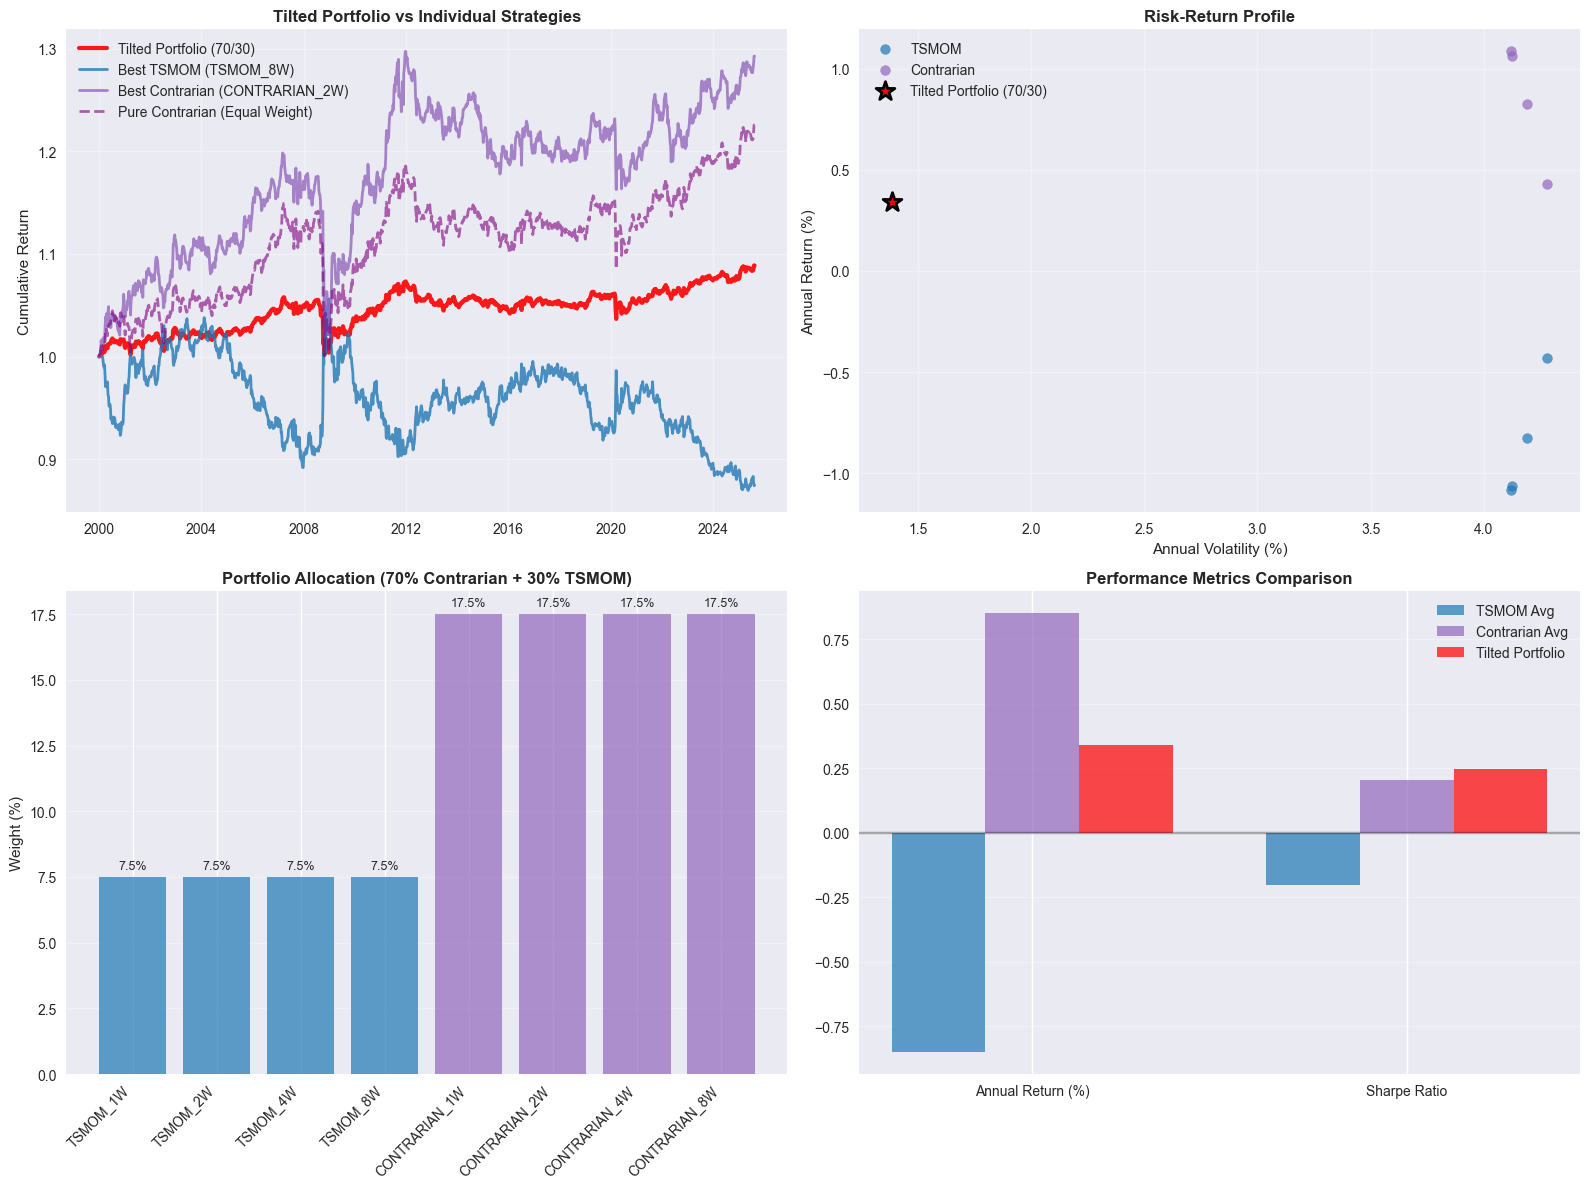

In [6]:
# Visualization: Portfolio vs Individual Strategies
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# Plot 1: Equity Curves Comparison
ax = axes[0]

# Plot tilted portfolio
ax.plot(portfolio_equity.index, portfolio_equity.values, 
        label='Tilted Portfolio (70/30)', color='red', linewidth=3, alpha=0.9)

# Plot best TSMOM and Contrarian
best_tsmom = individual_metrics.loc[tsmom_strategies, 'Sharpe_Ratio'].idxmax()
best_contrarian = individual_metrics.loc[contrarian_strategies, 'Sharpe_Ratio'].idxmax()

ax.plot(equity_curves.index, equity_curves[best_tsmom], 
        label=f'Best TSMOM ({best_tsmom})', color='#1f77b4', linewidth=2, alpha=0.8)
ax.plot(equity_curves.index, equity_curves[best_contrarian], 
        label=f'Best Contrarian ({best_contrarian})', color='#9467bd', linewidth=2, alpha=0.8)

# Add pure contrarian portfolio for comparison
pure_contrarian_equity = (1 + returns_data[contrarian_strategies].mean(axis=1)).cumprod()
ax.plot(pure_contrarian_equity.index, pure_contrarian_equity.values,
        label='Pure Contrarian (Equal Weight)', color='purple', linewidth=2, alpha=0.6, linestyle='--')

ax.set_title('Tilted Portfolio vs Individual Strategies', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Risk-Return Scatter
ax = axes[1]

# Plot individual strategies
for strategy in tsmom_strategies:
    ax.scatter(individual_metrics.loc[strategy, 'Annual_Vol'] * 100, 
              individual_metrics.loc[strategy, 'Annual_Return'] * 100,
              color='#1f77b4', alpha=0.7, s=50, label='TSMOM' if strategy == tsmom_strategies[0] else "")
    
for strategy in contrarian_strategies:
    ax.scatter(individual_metrics.loc[strategy, 'Annual_Vol'] * 100, 
              individual_metrics.loc[strategy, 'Annual_Return'] * 100,
              color='#9467bd', alpha=0.7, s=50, label='Contrarian' if strategy == contrarian_strategies[0] else "")

# Plot portfolio
ax.scatter(portfolio_metrics['Annual_Vol'] * 100, 
          portfolio_metrics['Annual_Return'] * 100,
          color='red', s=200, marker='*', 
          label='Tilted Portfolio (70/30)', edgecolors='black', linewidth=2)

ax.set_xlabel('Annual Volatility (%)')
ax.set_ylabel('Annual Return (%)')
ax.set_title('Risk-Return Profile', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Strategy Weights Visualization
ax = axes[2]
weights = portfolio_builder.strategy_weights * 100
colors = ['#1f77b4' if s.startswith('TSMOM') else '#9467bd' for s in weights.index]

bars = ax.bar(range(len(weights)), weights.values, color=colors, alpha=0.7)
ax.set_title('Portfolio Allocation (70% Contrarian + 30% TSMOM)', fontsize=12, fontweight='bold')
ax.set_ylabel('Weight (%)')
ax.set_xticks(range(len(weights)))
ax.set_xticklabels(weights.index, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, weight in zip(bars, weights.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
            f'{weight:.1f}%', ha='center', va='bottom', fontsize=9)

# Plot 4: Performance Metrics Comparison
ax = axes[3]
metrics_to_plot = ['Annual_Return', 'Sharpe_Ratio']
x_pos = np.arange(len(metrics_to_plot))

tsmom_values = [tsmom_avg_performance[m] * 100 if 'Return' in m else tsmom_avg_performance[m] for m in metrics_to_plot]
contrarian_values = [contrarian_avg_performance[m] * 100 if 'Return' in m else contrarian_avg_performance[m] for m in metrics_to_plot]
portfolio_values = [portfolio_metrics[m] * 100 if 'Return' in m else portfolio_metrics[m] for m in metrics_to_plot]

width = 0.25
ax.bar(x_pos - width, tsmom_values, width, label='TSMOM Avg', color='#1f77b4', alpha=0.7)
ax.bar(x_pos, contrarian_values, width, label='Contrarian Avg', color='#9467bd', alpha=0.7)
ax.bar(x_pos + width, portfolio_values, width, label='Tilted Portfolio', color='red', alpha=0.7)

ax.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(['Annual Return (%)', 'Sharpe Ratio'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/tilted_portfolio_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Save results
print("💾 Saving tilted portfolio analysis results...")

# Save portfolio equity curve and returns
portfolio_equity.to_frame('TILTED_PORTFOLIO_70_30').to_parquet('../results/tilted_portfolio_equity_curve.parquet')
portfolio_returns.to_frame('TILTED_PORTFOLIO_70_30').to_parquet('../results/tilted_portfolio_returns.parquet')

# Save performance metrics
portfolio_metrics_df = pd.DataFrame([portfolio_metrics], index=['TILTED_PORTFOLIO_70_30'])
portfolio_metrics_df.to_parquet('../results/tilted_portfolio_performance_metrics.parquet')

# Save comparison table
full_comparison.to_parquet('../results/tilted_portfolio_vs_individual_comparison.parquet')
comparison_display.to_csv('../results/tilted_portfolio_performance_comparison.csv')

# Generate summary report
report = []
report.append("=" * 70)
report.append("TILTED PORTFOLIO ANALYSIS REPORT (70% Contrarian + 30% TSMOM)")
report.append("=" * 70)
report.append(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
report.append(f"Data Period: {equity_curves.index[0].strftime('%Y-%m-%d')} to {equity_curves.index[-1].strftime('%Y-%m-%d')}")
report.append(f"Total Observations: {len(equity_curves)} weeks")
report.append("")

report.append("PORTFOLIO COMPOSITION:")
report.append(f"- Number of Strategies: {len(returns_data.columns)}")
report.append(f"- TSMOM Strategies: {len(tsmom_strategies)} @ 7.5% each ({', '.join(tsmom_strategies)})")
report.append(f"- Contrarian Strategies: {len(contrarian_strategies)} @ 17.5% each ({', '.join(contrarian_strategies)})")
report.append(f"- Weighting Scheme: 70% Contrarian + 30% TSMOM")
report.append(f"- Rebalancing: Weekly (every Friday)")
report.append(f"- Rationale: Performance-based tilting towards positive strategies")
report.append("")

report.append("PORTFOLIO PERFORMANCE:")
report.append(f"- Total Return: {portfolio_metrics['Total_Return'] * 100:+.2f}%")
report.append(f"- Annual Return: {portfolio_metrics['Annual_Return'] * 100:+.2f}%")
report.append(f"- Annual Volatility: {portfolio_metrics['Annual_Vol'] * 100:.2f}%")
report.append(f"- Sharpe Ratio: {portfolio_metrics['Sharpe_Ratio']:.3f}")
report.append(f"- Maximum Drawdown: {portfolio_metrics['Max_Drawdown'] * 100:.2f}%")
report.append("")

report.append("PERFORMANCE ATTRIBUTION:")
report.append(f"- Expected Return (70/30 mix): {expected_tilted * 100:+.2f}%")
report.append(f"- Actual Portfolio Return: {actual_tilted * 100:+.2f}%")
report.append(f"- Diversification Alpha: {diversification_alpha * 100:+.2f}%")
report.append(f"- Contrarian Average Return: {contrarian_avg_performance['Annual_Return'] * 100:+.2f}%")
report.append(f"- TSMOM Average Return: {tsmom_avg_performance['Annual_Return'] * 100:+.2f}%")
report.append("")

report.append("BENCHMARK COMPARISON:")
report.append(f"- Best Individual Strategy: {best_individual} (Sharpe: {best_sharpe:.3f})")
report.append(f"- Portfolio vs Best Individual: {portfolio_sharpe - best_sharpe:+.3f} Sharpe difference")
report.append(f"- Average Individual Sharpe: {avg_individual_sharpe:.3f}")
report.append(f"- Portfolio vs Average: {portfolio_sharpe - avg_individual_sharpe:+.3f} improvement")
report.append("")

report.append("KEY FINDINGS:")
if portfolio_sharpe > best_sharpe:
    report.append("✅ Tilted portfolio outperforms best individual strategy")
else:
    report.append("❌ Tilted portfolio underperforms best individual strategy")
    
if diversification_alpha > 0:
    report.append("✅ Positive diversification alpha from strategy combination")
else:
    report.append("❌ Negative diversification alpha - simple mix would be better")
    
if portfolio_metrics['Sharpe_Ratio'] > contrarian_avg_performance['Sharpe_Ratio']:
    report.append("✅ Tilted portfolio improves on pure contrarian approach")
else:
    report.append("❌ Pure contrarian would be better than tilted portfolio")

report.append("")
report.append("=" * 70)

# Save report
with open('../results/tilted_portfolio_analysis_report.txt', 'w') as f:
    f.write('\n'.join(report))

print("✅ All tilted portfolio analysis results saved!")
print("\nFiles created:")
print("- tilted_portfolio_equity_curve.parquet")
print("- tilted_portfolio_returns.parquet") 
print("- tilted_portfolio_performance_metrics.parquet")
print("- tilted_portfolio_vs_individual_comparison.parquet")
print("- tilted_portfolio_performance_comparison.csv")
print("- tilted_portfolio_analysis.png")
print("- tilted_portfolio_analysis_report.txt")

# Display final summary
print("\n" + "\n".join(report[-10:]))  # Show key findings section

💾 Saving tilted portfolio analysis results...
✅ All tilted portfolio analysis results saved!

Files created:
- tilted_portfolio_equity_curve.parquet
- tilted_portfolio_returns.parquet
- tilted_portfolio_performance_metrics.parquet
- tilted_portfolio_vs_individual_comparison.parquet
- tilted_portfolio_performance_comparison.csv
- tilted_portfolio_analysis.png
- tilted_portfolio_analysis_report.txt

- Portfolio vs Best Individual: -0.017 Sharpe difference
- Average Individual Sharpe: 0.000
- Portfolio vs Average: +0.246 improvement

KEY FINDINGS:
❌ Tilted portfolio underperforms best individual strategy
❌ Negative diversification alpha - simple mix would be better
✅ Tilted portfolio improves on pure contrarian approach

